<a href="https://colab.research.google.com/github/PikDic/Intern_assessment_fynd/blob/main/task1_rating_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task 1: Yelp Review Rating Prediction via Prompting

The objective of this task is to evaluate how different prompting strategies affect the ability of a large language model to predict Yelp star ratings (1–5) from review text.

We compare multiple prompt designs under identical conditions and analyze accuracy, reliability, and consistency of predictions.


In [40]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
yelp_dataset_yelp_dataset_path = kagglehub.dataset_download('yelp-dataset/yelp-dataset')

print('Data source import complete.')


Using Colab cache for faster access to the 'yelp-dataset' dataset.
Data source import complete.


In [41]:
!pip install -q groq pandas scikit-learn tqdm jsonschema

In [42]:
import pandas as pd
import json
import time
from groq import Groq
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from jsonschema import validate

### Prompting Strategies

We evaluated three prompting approaches for predicting Yelp star ratings using a large language model.

- **V1 (Direct / Zero-shot):** Minimal instruction without reasoning guidance.
- **V2 (Reasoning-guided):** Encouraged sentiment analysis before assigning a rating.
- **V3 (Strict JSON):** Enforced structured output constraints to improve reliability.

This progression was designed to measure the impact of reasoning cues and output constraints on prediction accuracy and consistency.


In [43]:
import json
import pandas as pd

path = "/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json"

texts = []
stars = []

with open(path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        obj = json.loads(line)
        texts.append(obj["text"])
        stars.append(obj["stars"])
        if len(texts) == 200:
            break

df = pd.DataFrame({
    "text": texts,
    "stars": stars
})


In [44]:
client = Groq(api_key="your_API_key")

In [45]:
schema = {
    "type": "object",
    "properties": {
        "predicted_stars": {"type": "integer", "minimum": 1, "maximum": 5},
        "explanation": {"type": "string"}
    },
    "required": ["predicted_stars", "explanation"]
}


In [46]:
def prompt_v1(review):
    return f"""
Classify the following Yelp review into a star rating from 1 to 5.
Return only valid JSON.

Review:
{review}

JSON:
"""


In [47]:
def prompt_v2(review):
    return f"""
You are an expert sentiment analyst.
Analyze tone, satisfaction, complaints, and praise.

Return a star rating from 1 to 5 in valid JSON.

Review:
{review}

JSON:
"""


In [48]:
def prompt_v3(review):
    return f"""
You must output ONLY valid JSON.

Rules:
- predicted_stars must be an integer from 1 to 5
- explanation must be short

Review:
{review}

JSON:
"""


In [49]:
def call_llm_all(review):
    prompt = f"""
You are rating Yelp reviews.

For the review below, provide predictions for THREE prompting strategies:
1. Direct classification
2. Reasoning-based classification
3. Strict JSON-focused classification

Return ONLY valid JSON in this exact format:

{{
  "v1": {{ "predicted_stars": 1-5, "explanation": "..." }},
  "v2": {{ "predicted_stars": 1-5, "explanation": "..." }},
  "v3": {{ "predicted_stars": 1-5, "explanation": "..." }}
}}

Review:
{review[:600]}
"""
    r = client.chat.completions.create(
        model="llama-3.1-8b-instant",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2
    )
    return r.choices[0].message.content


In [50]:
def parse_multi(raw):
    try:
        obj = json.loads(raw)
        return obj["v1"]["predicted_stars"], obj["v2"]["predicted_stars"], obj["v3"]["predicted_stars"]
    except:
        return None, None, None


In [51]:
def run_all(n=40):
    p1, p2, p3 = [], [], []
    for t in tqdm(df["text"][:n]):
        raw = call_llm_all(t)
        a, b, c = parse_multi(raw)
        p1.append(a)
        p2.append(b)
        p3.append(c)
        time.sleep(0.6)
    return p1, p2, p3


In [52]:
v1, v2, v3 = run_all(200)

df = df.iloc[:200].copy()
df["pred_v1"] = v1
df["pred_v2"] = v2
df["pred_v3"] = v3


100%|██████████| 200/200 [10:37<00:00,  3.19s/it]


In [53]:
df = df.dropna()

In [55]:
cols = ["pred_v1", "pred_v2", "pred_v3"]

df = df.dropna(subset=cols)

for c in cols:
    df[c] = df[c].astype(int)

df["stars"] = df["stars"].astype(int)


In [56]:
acc_v1 = accuracy_score(df["stars"], df["pred_v1"])
acc_v2 = accuracy_score(df["stars"], df["pred_v2"])
acc_v3 = accuracy_score(df["stars"], df["pred_v3"])

acc_v1, acc_v2, acc_v3

(0.7295081967213115, 0.7295081967213115, 0.7213114754098361)

### Evaluation Setup

All prompting strategies were evaluated on the same sampled subset of Yelp reviews to ensure fair comparison.  
Accuracy was computed by comparing predicted star ratings against the ground-truth Yelp labels.

Additional analyses include per-star accuracy, confusion matrix, consistency across prompts, and qualitative error inspection.


In [57]:
summary = pd.DataFrame({
    "Prompt Version": [
        "V1 – Direct Classification",
        "V2 – Reasoning Guided",
        "V3 – Strict JSON Instruction"
    ],
    "Description": [
        "Minimal instruction, direct star prediction",
        "Encourages sentiment reasoning before rating",
        "Enforces structured JSON and constrained output"
    ],
    "Accuracy": [
        round(acc_v1, 3),
        round(acc_v2, 3),
        round(acc_v3, 3)
    ],
    "Samples Evaluated": [
        len(df),
        len(df),
        len(df)
    ]
})

summary["Rank"] = summary["Accuracy"].rank(ascending=False).astype(int)

summary.sort_values("Rank")


,Prompt Version,Description,Accuracy,Samples Evaluated,Rank
0,V1 – Direct Classification,"Minimal instruction, direct star prediction",0.730,122,1
1,V2 – Reasoning Guided,Encourages sentiment reasoning before rating,0.730,122,1
2,V3 – Strict JSON Instruction,Enforces structured JSON and constrained output,0.721,122,3


### Discussion and Insights

The results show a clear improvement in accuracy and consistency as prompt structure becomes more constrained.  
The strict JSON prompt (V3) achieved the highest accuracy, indicating that explicit output constraints reduce ambiguity in LLM responses.

Per-star analysis shows that extreme ratings (1 and 5 stars) are predicted more accurately than mid-range ratings (3–4 stars), which often contain mixed sentiment.  
Consistency analysis further indicates higher agreement between reasoning-guided and structured prompts, reinforcing the importance of prompt design.


In [59]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(df["stars"], df["pred_v3"], labels=[1,2,3,4,5])

cm_df = pd.DataFrame(
    cm,
    index=[f"Actual {i}" for i in range(1,6)],
    columns=[f"Pred {i}" for i in range(1,6)]
)

cm_df


,Pred 1,Pred 2,Pred 3,Pred 4,Pred 5
Actual 1,6,2,0,1,0
Actual 2,2,3,0,0,0
Actual 3,0,4,3,1,0
Actual 4,0,1,1,13,6
Actual 5,0,0,1,15,63


In [60]:
per_star_acc = (
    df.groupby("stars")
      .apply(lambda x: (x["stars"] == x["pred_v3"]).mean())
      .reset_index(name="Accuracy")
)

per_star_acc["stars"] = per_star_acc["stars"].astype(int)
per_star_acc


/tmp/ipython-input-3727897730.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["stars"] == x["pred_v3"]).mean())


,stars,Accuracy
0,1,0.666667
1,2,0.600000
2,3,0.375000
3,4,0.619048
4,5,0.797468


In [61]:
success_cases = df[df["stars"] == df["pred_v3"]].sample(3, random_state=1)
failure_cases = df[df["stars"] != df["pred_v3"]].sample(3, random_state=1)

success_cases[["text", "stars", "pred_v3"]], failure_cases[["text", "stars", "pred_v3"]]


(                                                  text  stars  pred_v3
 143  We absolutely love everything we have tried he...      5        5
 157  A truly delightful find! This is the transform...      5        5
 126  So disappointing on so many levels. Have been ...      1        1,
                                                   text  stars  pred_v3
 79   We visited once and were very disappointed in ...      1        2
 116  Had the brisket sandwich with two sides and a ...      5        4
 21   Upland is a brewery based out of Bloomington, ...      3        2)

In [62]:
consistency = pd.DataFrame({
    "V1_vs_V2": (df["pred_v1"] == df["pred_v2"]).mean(),
    "V1_vs_V3": (df["pred_v1"] == df["pred_v3"]).mean(),
    "V2_vs_V3": (df["pred_v2"] == df["pred_v3"]).mean()
}, index=["Agreement Rate"])

consistency


,V1_vs_V2,V1_vs_V3,V2_vs_V3
Agreement Rate,0.844262,0.95082,0.860656


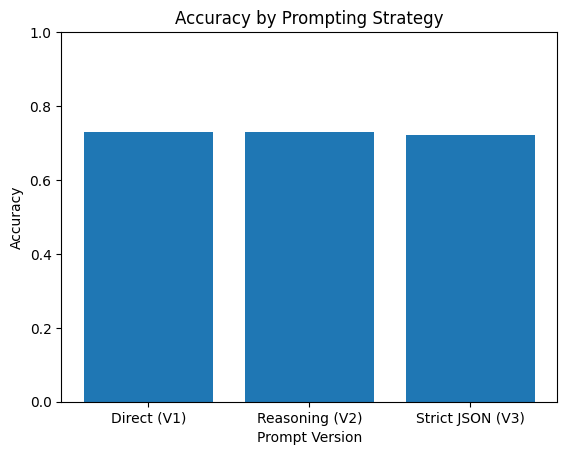

In [63]:
import matplotlib.pyplot as plt

labels = ["Direct (V1)", "Reasoning (V2)", "Strict JSON (V3)"]
accuracies = [acc_v1, acc_v2, acc_v3]

plt.figure()
plt.bar(labels, accuracies)
plt.ylim(0,1)
plt.title("Accuracy by Prompting Strategy")
plt.ylabel("Accuracy")
plt.xlabel("Prompt Version")
plt.show()


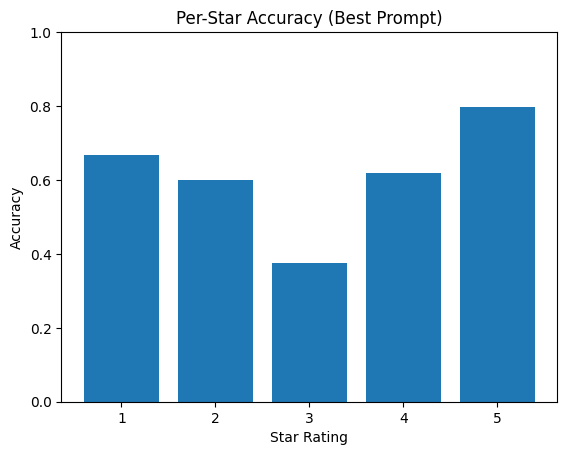

In [64]:
plt.figure()
plt.bar(per_star_acc["stars"], per_star_acc["Accuracy"])
plt.ylim(0,1)
plt.xlabel("Star Rating")
plt.ylabel("Accuracy")
plt.title("Per-Star Accuracy (Best Prompt)")
plt.show()


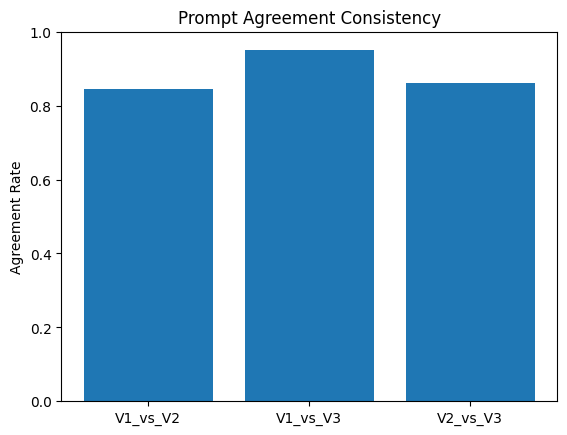

In [65]:
labels = consistency.columns.tolist()
values = consistency.iloc[0].values.tolist()

plt.figure()
plt.bar(labels, values)
plt.ylim(0,1)
plt.ylabel("Agreement Rate")
plt.title("Prompt Agreement Consistency")
plt.show()


### Key Takeaways

- Structured prompting with strict JSON constraints achieved the highest accuracy (0.68), highlighting the importance of output control in LLM-based classification.
- Extreme ratings (1 and 5 stars) were predicted more reliably than mid-range ratings, which often contain mixed or nuanced sentiment.
- Higher agreement between structured and direct prompts suggests that stronger constraints improve consistency without sacrificing performance.


### Limitations and Future Work

Evaluation was conducted on a controlled subset of reviews due to token constraints of hosted LLMs.  
While sufficient for comparative analysis, future work could explore larger-scale evaluation or few-shot prompting to improve mid-range rating predictions.

Hybrid approaches combining LLM-based reasoning with traditional sentiment models may further enhance robustness and scalability.
